## Well

Some preliminaries...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import welly
welly.__version__

'0.4.2'

In [2]:
import os
env = %env

## Load a well from LAS

Use the `from_las()` method to load a well by passing a filename as a `str`. 

This is really just a wrapper for `lasio` but instantiates a `Header`, `Curve`s, etc.

In [3]:
from welly import Well

In [4]:
w = Well.from_las('P-129_out.LAS')

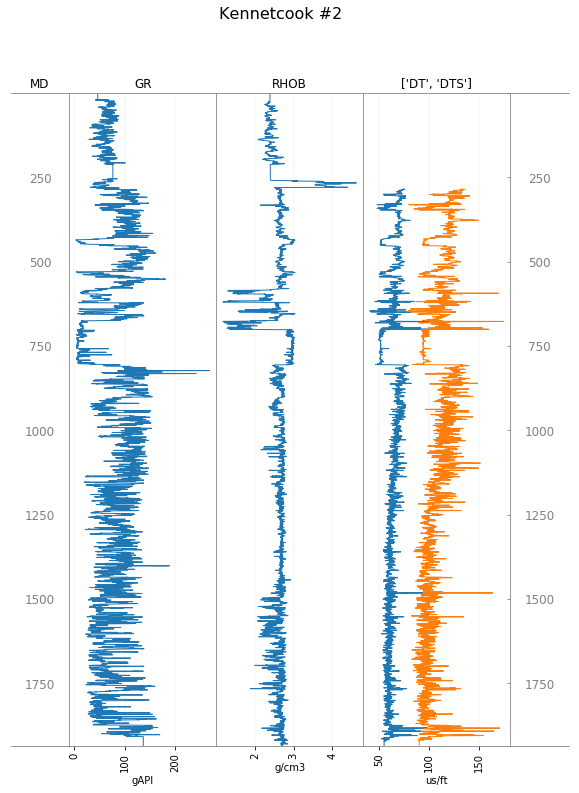

In [5]:
tracks = ['MD', 'GR', 'RHOB', ['DT', 'DTS'], 'MD']
w.plot(tracks=tracks)

## Aliases and curve quality

We can define aliases for curves, and check the quality of curves with a dictionary of tests:

In [6]:
alias = {
    "Gamma": ["GR", "GAM", "GRC", "SGR", "NGT"],
    "Density": ["RHOZ", "RHOB", "DEN", "RHOZ"],
    "Sonic": ["DT", "AC", "DTP", "DT4P"],
    "Caliper": ["CAL", "CALI", "CALS", "C1"],
    'Porosity SS': ['NPSS', 'DPSS'],
}

In [7]:
import welly.quality as q

tests = {
    'Each': [
        q.no_flat,
        q.no_monotonic,
        q.no_gaps,
    ],
    'Gamma': [
        q.all_positive,
        q.all_below(450),
        q.check_units(['API', 'GAPI']),
    ],
    'DT': [
        q.all_positive,
    ],
    'Sonic': [
        q.all_between(1, 10000),  # 1333 to 5000 m/s
        q.no_spikes(10),          # 10 spikes allowed
    ],
}

In [10]:
w = Well.from_las('P-129_out.LAS')
r = w.qc_data(tests, alias=alias)

This returns a dictionary of curves in which the values are dictionaries of **test name: test result** pairs.

In [11]:
r

{'CALI': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'HCAL': {'no_flat': False, 'no_monotonic': False, 'no_gaps': False},
 'PEF': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'DT': {'no_flat': True,
  'no_monotonic': True,
  'no_gaps': False,
  'all_positive': True,
  'all_between': True,
  'no_spikes': False},
 'DTS': {'no_flat': True, 'no_monotonic': True, 'no_gaps': False},
 'DPHI_SAN': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'DPHI_LIM': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'DPHI_DOL': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'NPHI_SAN': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'NPHI_LIM': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'NPHI_DOL': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'RLA5': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'RLA3': {'no_flat': False, 'no_monotonic': False, 'no_gaps': True},
 'RLA4': {'

There's also an HTML table for rendering in Notebooks:

In [9]:
from IPython.display import HTML
html = w.qc_table_html(tests, alias=alias)
HTML(html)

Curve,Passed,Score,no_spikes,all_between,check_units,no_monotonic,no_gaps,no_flat,all_positive,all_below
CALI,1 / 3,0.333,,,,False,True,False,,
HCAL,0 / 3,0.000,,,,False,False,False,,
PEF,1 / 3,0.333,,,,False,True,False,,
DT,4 / 6,0.667,False,True,,True,False,True,True,
DTS,2 / 3,0.667,,,,True,False,True,,
DPHI_SAN,1 / 3,0.333,,,,False,True,False,,
DPHI_LIM,1 / 3,0.333,,,,False,True,False,,
DPHI_DOL,1 / 3,0.333,,,,False,True,False,,
NPHI_SAN,1 / 3,0.333,,,,False,True,False,,
NPHI_LIM,1 / 3,0.333,,,,False,True,False,,


## Add a striplog

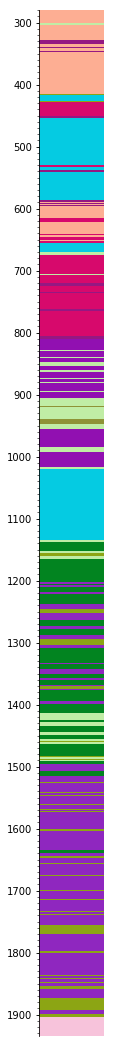

In [12]:
from striplog import Legend, Striplog
legend = Legend.builtin('NSDOE')
strip = Striplog.from_image('P-129_280_1935.png', 280, 1935, legend=legend)
strip.plot()

In [13]:
w.data['strip'] = strip

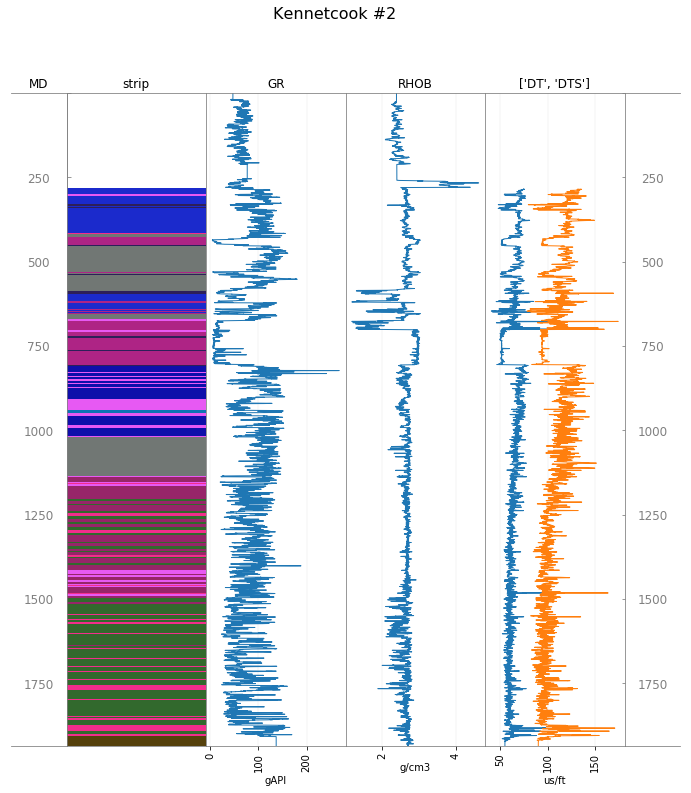

In [14]:
tracks = ['MD', 'strip', 'GR', 'RHOB', ['DT', 'DTS'], 'MD']
w.plot(tracks=tracks)

## Header

Maybe should be called 'meta' as it's not really a header... 

In [15]:
w.header

{'name': 'Kennetcook #2', 'field': 'Windsor Block', 'license': 'P-129', 'uwi': "Long = 63* 45'24.460  W", 'company': 'Elmworth Energy Corporation'}

In [16]:
w.header.name

'Kennetcook #2'

In [17]:
w.uwi  # Fails because not present in this file. See one way to add it in a minute.

"Long = 63* 45'24.460  W"

## Location and CRS

In [18]:
w.location

Location({'td': 1935.0, 'crs': CRS({}), 'location': 'Lat = 45* 12\' 34.237" N', 'country': 'CA', 'province': 'Nova Scotia', 'section': '45.20 Deg N', 'range': 'PD 176', 'township': '63.75 Deg W', 'kb': 94.8, 'gl': 90.3, 'tdd': 1935.0, 'tdl': 1935.0, 'deviation': None, 'position': None})

In [19]:
from welly import CRS
w.location.crs = CRS.from_epsg(2038)

In [20]:
w.location.crs

CRS({'init': 'epsg:2038', 'no_defs': True})

Right now there's no position log — we need to load a deviation survey.

In [21]:
w.location.position

## Add deviation data to a well

In [22]:
p = Well.from_las('P-130_out.LAS')

In [23]:
dev = np.loadtxt('P-130_deviation_survey.csv', delimiter=',', skiprows=1)

The columns are MD, inclination, azimuth, and TVD.

In [24]:
dev[:5]

array([[ 18. ,   0.3,   0. ,  18. ],
       [ 38. ,   0.5,   0. ,  38. ],
       [ 57. ,   1.5,   0. ,  57. ],
       [ 84. ,   1.8,   0. ,  84. ],
       [104. ,   0.5,   0. , 104. ]])

`add_deviation` assumes those are the columns, and computes a position log.

In [25]:
p.location.add_deviation(dev[:, :3], td=2618.3)

The columns in the position log are _x_ offset, _y_ offset, and TVD.

In [26]:
p.location.position[:5]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.71237821e-02, 0.00000000e+00, 1.79999178e+01],
       [1.86748917e-01, 0.00000000e+00, 3.79994202e+01],
       [5.18340431e-01, 0.00000000e+00, 5.69962853e+01],
       [1.29577626e+00, 0.00000000e+00, 8.39850594e+01]])

## Export curves to data matrix

Make a NumPy array:

In [27]:
w.data_as_matrix()

array([[  2.44381547,   4.39128494,   3.58640003, ...,   2.39014983,
         46.69865036, 120.125     ],
       [  2.44381547,   4.39128494,   3.58640003, ...,   2.39014983,
         46.69865036, 120.125     ],
       [  2.44381547,   4.39128494,   3.58640003, ...,   2.39014983,
         46.69865036, 120.125     ],
       ...,
       [  2.42026806,          nan,   2.23697996, ...,          nan,
         92.24622345,  73.        ],
       [  2.42026806,          nan,   2.23697996, ...,          nan,
         92.24622345,  73.9375    ],
       [  2.42026806,          nan,   2.23697996, ...,          nan,
         92.24622345,  74.25      ]])

## Export curves to pandas

Pandas is an optional dependency. You'll need it to make this work.

In [28]:
df = w.df()

In [29]:
df.head()

,CALI,HCAL,PEF,DT,DTS,DPHI_SAN,DPHI_LIM,DPHI_DOL,NPHI_SAN,NPHI_LIM,...,RLA2,RXOZ,RXO_HRLT,RT_HRLT,RM_HRLT,DRHO,RHOB,GR,SP,strip
Depth,,,,,,,,,,,,,,,,,,,,,
1.0668,2.443815,4.391285,3.5864,NaN,NaN,0.15748,0.19844,0.2591,0.4651,0.33647,...,0.02794,0.05761,0.02558,0.02558,0.05501,0.194233,2.39015,46.69865,120.125,NaN
1.2192,2.443815,4.391285,3.5864,NaN,NaN,0.15748,0.19844,0.2591,0.4651,0.33647,...,0.02794,0.05761,0.02558,0.02558,0.05501,0.194233,2.39015,46.69865,120.125,NaN
1.3716,2.443815,4.391285,3.5864,NaN,NaN,0.15748,0.19844,0.2591,0.4651,0.33647,...,0.02794,0.05761,0.02558,0.02558,0.05501,0.194233,2.39015,46.69865,120.125,NaN
1.5240,2.443815,4.391285,3.5864,NaN,NaN,0.15748,0.19844,0.2591,0.4651,0.33647,...,0.02794,0.05761,0.02558,0.02558,0.05501,0.194233,2.39015,46.69865,120.125,NaN
1.6764,2.443815,4.391285,3.5864,NaN,NaN,0.15748,0.19844,0.2591,0.4651,0.33647,...,0.02794,0.05761,0.02558,0.02558,0.05501,0.194233,2.39015,46.69865,120.125,NaN


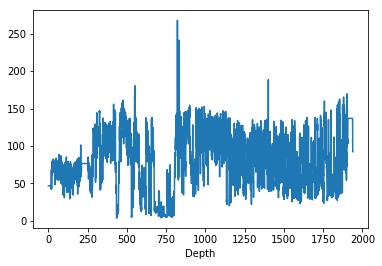

In [30]:
df.GR.plot()

This also gives us another path to getting a matrix:

In [31]:
w.df().values

array([[  2.44381547,   4.39128494,   3.58640003, ...,  46.69865036,
        120.125     ,          nan],
       [  2.44381547,   4.39128494,   3.58640003, ...,  46.69865036,
        120.125     ,          nan],
       [  2.44381547,   4.39128494,   3.58640003, ...,  46.69865036,
        120.125     ,          nan],
       ...,
       [  2.42026806,          nan,   2.23697996, ...,  92.24622345,
         73.        ,          nan],
       [  2.42026806,          nan,   2.23697996, ...,  92.24622345,
         73.9375    ,          nan],
       [  2.42026806,          nan,   2.23697996, ...,  92.24622345,
         74.25      ,          nan]])

You'll have to get depth separately:

In [32]:
w.df().index.values

array([1.0668000e+00, 1.2192000e+00, 1.3716000e+00, ..., 1.9388328e+03,
       1.9389852e+03, 1.9391376e+03])

To get the UWI of the well as well, e.g. if you want to combine multiple wells (maybe using `welly.Project.df()`):

In [33]:
df = w.df(uwi=True)

In [34]:
df.head()

CALI      HCAL     PEF  DT  DTS  DPHI_SAN  \
UWI                     Depth                                                   
Long = 63* 45'24.460  W 1.0668  2.443815  4.391285  3.5864 NaN  NaN   0.15748   
                        1.2192  2.443815  4.391285  3.5864 NaN  NaN   0.15748   
                        1.3716  2.443815  4.391285  3.5864 NaN  NaN   0.15748   
                        1.5240  2.443815  4.391285  3.5864 NaN  NaN   0.15748   
                        1.6764  2.443815  4.391285  3.5864 NaN  NaN   0.15748   

                                DPHI_LIM  DPHI_DOL  NPHI_SAN  NPHI_LIM  ...    \
UWI                     Depth                                           ...     
Long = 63* 45'24.460  W 1.0668   0.19844    0.2591    0.4651   0.33647  ...     
                        1.2192   0.19844    0.2591    0.4651   0.33647  ...     
                        1.3716   0.19844    0.2591    0.4651   0.33647  ...     
                        1.5240   0.19844    0.2591    0.4651   0.33647  ...     
                        1.6764   0.19844    0.2591    0.4651   0.33647  ...     

                                   RLA2     RXOZ  RXO_HRLT  RT_HRLT  RM_HRLT  \
UWI                     Depth                                                  
Long = 63* 45'24.460  W 1.0668  0.02794  0.05761   0.02558  0.02558  0.05501   
                        1.2192  0.02794  0.05761   0.02558  0.02558  0.05501   
                        1.3716  0.02794  0.05761   0.02558  0.02558  0.05501   
                        1.5240  0.02794  0.05761   0.02558  0.02558  0.05501   
                        1.6764  0.02794  0.05761   0.02558  0.02558  0.05501   

                                    DRHO     RHOB        GR       SP  strip  
UWI                     Depth                                                
Long = 63* 45'24.460  W 1.0668  0.194233  2.39015  46.69865  120.125    NaN  
                        1.2192  0.194233  2.39015  46.69865  120.125    NaN  
                        1.3716  0.194233  2.39015  46.69865  120.125    NaN  
                        1.5240  0.194233  2.39015  46.69865  120.125    NaN  
                        1.6764  0.194233  2.39015  46.69865  120.125    NaN  

[5 rows x 25 columns]